## オンラインストア購買についてのデータセット

データの取得
- https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

データの説明
- https://archive.ics.uci.edu/ml/datasets/online+retail

### データセットの読み込み

```pd.read_excel()``` によりExcelファイルを読み込む

- pandas 内部で xlrd パッケージを使用
  - Anaconda ではインストール済み（のはず）
  - もしエラーが出る場合はインストール（エラーが出た場合のみ）<br>
```conda install xlrd```

In [1]:
%%time
# - セルの実行時間の計測
#   MacBook Pro M1 で約40秒
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

trans = pd.read_excel('data/Online Retail.xlsx')
trans.head()

Wall time: 1min 44s


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


InvoiceNo の先頭1文字は各トランザクションの状態を表す

- '5' 通常データ
- 'C' キャンセル
- 'A' 不明

In [2]:
# InvoiceNo の先頭1文字の種類を確認
trans.InvoiceNo.map(lambda x: str(x)[0]).unique()

array(['5', 'C', 'A'], dtype=object)

In [3]:
# InvoiceNo の先頭1文字が '5' の行のみを取り出す
trans = trans[trans.InvoiceNo.map(lambda x: True if str(x)[0] == '5' else False)]

# InvoiceNo の先頭1文字が '5' だけになっているか確認
trans.InvoiceNo.map(lambda x: str(x)[0]).unique()

array(['5'], dtype=object)

### データ形式の変換

必要なデータ

- 購買履歴のデータ
  - TID, ItemID 列からなる pandas DataFrame
```
ワインの購買履歴のデータの場合
TID, ItemID
  1, 'I1'
```
- ItemIDとアイテム名の辞書
  - キーが ItemID, バリューがアイテム名の dict 型
```
# ItemIDとアイテム名の辞書
item_dict = {
    'I1': 'フランスワイン',
    ...
}
```

In [4]:
# 処理対象のデータを確認
trans.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom


In [5]:
# 購買履歴のデータを作成
# - InvoiceNo: TID
# - StockCode: ItemID
#   - 文字列と数値が混在しているため、文字列に統一（しないと比較でエラーになる）
df = pd.concat([trans.InvoiceNo, trans['StockCode'].astype(str)], axis=1)

# 列名を 'TID', 'ItemID' に設定
df.columns = ['TID', 'ItemID']

# 確認
df.head(2)

,TID,ItemID
0,536365,85123A
1,536365,71053


In [6]:
# ItemIDとアイテム名の辞書を作成
# - StockCode: ItemID
# - Description: アイテム名
df_dict = pd.concat([trans['StockCode'].astype(str), trans.Description], axis=1)
df_dict.columns = ['ItemID', 'Item Name']

# dict 型に変換
# - drop_duplicates(): 行の重複排除
# - itertuples(): 1行ずつ取り出すメソッド
item_dict = {}
#for row in df_dict.drop_duplicates(keep='first').itertuples():
for row in df_dict.dropna().drop_duplicates(keep='first').itertuples():
    item_dict[row[1]] = row[2]

# 確認
# - item_dict
for i in df.ItemID.head(2):
    print(i, item_dict[i])

85123A CREAM HANGING HEART T-LIGHT HOLDER
71053 WHITE MOROCCAN METAL LANTERN


<hr>

### データの可視化

- アイテムの頻度の棒グラフ

In [7]:
# StockCode 列の要素の頻度
# - value_counts(): 出現回数が多いものから順にソート（降順）
df_counts = pd.DataFrame(df['ItemID'].value_counts())

# 列名の設定
df_counts.columns=['counts']

# 出現頻度上位5項目
df_counts.head(5)

,counts
85123A,2271
85099B,2115
22423,2022
47566,1707
20725,1595


[]

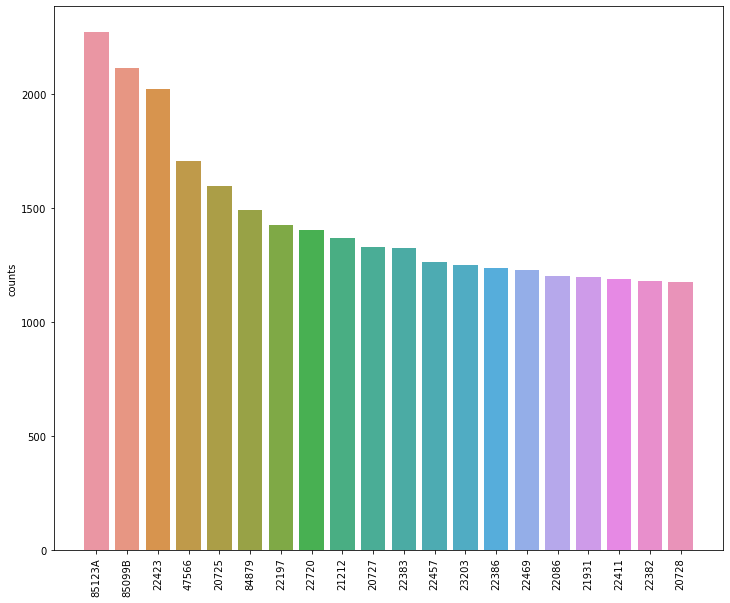

In [8]:
# 出現頻度上位20項目
df_bar = df_counts.head(20)

# 棒グラフ
plt.figure(figsize=(12, 10))
bar = sns.barplot(x=df_bar.index, y=df_bar.counts)

# 項目名を縦書き（90度回転）
bar.set_xticklabels(labels=df_bar.index, rotation=90)

# 戻り値の表示を抑制
plt.plot()

<hr>

### 相関ルール生成のプログラム

In [ ]:
%%time
# - セルの実行時間の計測
# MacBook Pro M1 で約120秒
# TIDを重複排除のため集合に変換
all_trans = set(df.TID)
# |D| : トランザクション数
all_trans_len = len(all_trans)

# 1つのitemについて、そのitemを含むTIDの集合を辞書で管理
count_dict = {}
# 全てのitemについて、そのitemを含むTIDの集合をtrans_setに追加
for item in df.ItemID.unique():
    count_dict[item] = set(df[df['ItemID'] == item].TID)

In [15]:
from functools import reduce
from itertools import combinations

# サポートカウントの計算
def support_count(item_set):
    trans_set = []
    # item_setの各itemについて、そのitemを含むTIDの集合をtrans_setに追加
    for item in item_set:
        trans_set.append(count_dict[item])
    # trans_set の確認用
    # print(trans_set)
    # 全itemを含むTIDは、各itemを含むTIDの集合の積集合の要素数
    return len(reduce(lambda a, x: a & x, trans_set, all_trans))

# サポートの計算
def support(itemset):
    return support_count(itemset) / all_trans_len

# コンフィデンスの計算
def confidence(itemset_A, itemset_B):
    return support_count(itemset_A | itemset_B) / support_count(itemset_A)

# Generate_Candidates(L_{k-1}, k, min_sup_count)
def generate_candidates(L, k, min_sup_count):
    Ck = []
    for l1 in L:
        for l2 in L:
            # listのインデックスは 0 始まり
            if l1[0:k - 2] == l2[0:k - 2] and l1[k - 2] < l2[k - 2]:
                c = sorted(list(set(l1) | set(l2)))
                # print('k={}: {} | {} = {}'.format(k, l1, l2, c))
                for i in combinations(c, k - 1):
                    if support_count(i) < min_sup_count:
                        break
                else:   # 上のbreak文が実行されなかった場合
                    Ck.append(c)
    return Ck

# Apriori アルゴリズムの処理
def apriori():
    # 全てのアイテム
    all_items = sorted(list(set(df.ItemID)))

    # 頻出アイテムセットの集合を格納するdict型変数
    L = {}

    # L1 ← 1つのアイテムからなる頻出アイテムセットの集合
    L[1] = [[i] for i in all_items if support_count({i}) >= min_sup_count]
    # print('L1 = ', L[1])

    # k ← 2
    k = 2

    while L[k - 1] != []:
        Lk = []
        Ck = generate_candidates(L[k - 1], k, min_sup_count)
        for c in Ck:
            # print('{} {}'.format(c, support_count(c)))
            if support_count(c) >= min_sup_count:
                Lk.append(c)
        L[k] = Lk
        # print('L{} = {}'.format(k, L[k]))
        k = k + 1
    
    # 和集合
    L_union = []
    for ln in L.values():
        for l in ln:
            L_union.append(l)

    return L_union

# 相関ルールの生成
def create_assoc_rules(l, v=0):
    # 相関ルールの初期化
    assoc_rule = []
    # 全ての真部分集合 all_s のリストを初期化
    all_s = []
    # 全ての真部分集合 all_s の作成
    for n in range(1, len(l)):
        for i in combinations(l, n):
            all_s.append(list(i))
    # all_sの確認
    #print('all_s = {}'.format(all_s))

    # lのサポートカウント
    l_support_count = support_count(l)

    # 各真部分集合についてコンフィデンスを計算
    for s in all_s:
        # コンフィデンス(s ⇒ (l-s))
        s_support_count = support_count(s)
        cnfd = l_support_count / s_support_count
        # 確認用
        if (v > 0):
            print('{} {}/{}={}'.format(s, l_support_count, s_support_count, cnfd))
        # 最小コンフィデンス以上のルールを相関ルールに追加
        if cnfd >= min_confidence:
            # (l-s)
            l_s = [i for i in l if i not in s]
            sprt = l_support_count / all_trans_len
            lift = cnfd / (support_count(l_s) / all_trans_len)
            assoc_rule.append([s, l_s, sprt, cnfd, lift])

    return assoc_rule

# 全ての相関ルールの生成
def create_all_assoc_rules():
    # 相関ルールの初期化
    assoc_rules = []
    # Aprioriアルゴリズムで求めた全ての頻出アイテムセットから相関ルールを生成
    for l in apriori():
        rules = create_assoc_rules(l)
        if rules != []:
            for r in rules:
                assoc_rules.append(r)

    return pd.DataFrame(assoc_rules, columns=['L', 'R', 'support', 'confidence', 'lift'])

<hr>

# 相関ルールの生成、リフト値の計算

1. Aprioriアルゴリズムを適用し、相関ルールを生成する
2. 各相関ルールについて、リフト値を計算する

In [16]:
# 最小サポート: 2.5%
min_sup = 0.025
# 最小コンフィデンス: 30%
min_confidence = 0.3

# 最小サポートカウント
min_sup_count = all_trans_len * min_sup
# 表示
print('all_trans_len:', all_trans_len)
print('min_sup_count:', min_sup_count)

# 相関ルールの生成
print('全ての相関ルールの生成:')
df_rules = create_all_assoc_rules()
# 確認
# - リフト値でソート（降順）
df_rules.sort_values('lift', ascending=False)

all_trans_len: 22061
min_sup_count: 551.525
全ての相関ルールの生成:


,L,R,support,confidence,lift
22,[22698],[22697],0.028693,0.825293,17.937731
21,[22697],[22698],0.028693,0.623645,17.937731
25,[22698],[22699],0.027152,0.780965,16.162162
26,[22699],[22698],0.027152,0.561914,16.162162
23,[22697],[22699],0.034813,0.756650,15.658969
24,[22699],[22697],0.034813,0.720450,15.658969
28,[22727],[22726],0.029010,0.608944,13.680153
27,[22726],[22727],0.029010,0.651731,13.680153
16,[22910],[22086],0.025022,0.673171,12.802431
15,[22086],[22910],0.025022,0.475862,12.802431


In [17]:
# アイテム名に変換して表示
df_high_rules = df_rules.sort_values('lift', ascending=False)
for rule in df_high_rules.itertuples():
    L_list = []
    R_list = []
    for i in rule.L:
        L_list.append(item_dict[i])
    for i in rule.R:
        R_list.append(item_dict[i])
    print(L_list, '=>', R_list)

['PINK REGENCY TEACUP AND SAUCER'] => ['GREEN REGENCY TEACUP AND SAUCER']
['GREEN REGENCY TEACUP AND SAUCER'] => ['PINK REGENCY TEACUP AND SAUCER']
['PINK REGENCY TEACUP AND SAUCER'] => ['ROSES REGENCY TEACUP AND SAUCER ']
['ROSES REGENCY TEACUP AND SAUCER '] => ['PINK REGENCY TEACUP AND SAUCER']
['GREEN REGENCY TEACUP AND SAUCER'] => ['ROSES REGENCY TEACUP AND SAUCER ']
['ROSES REGENCY TEACUP AND SAUCER '] => ['GREEN REGENCY TEACUP AND SAUCER']
['ALARM CLOCK BAKELIKE RED '] => ['ALARM CLOCK BAKELIKE GREEN']
['ALARM CLOCK BAKELIKE GREEN'] => ['ALARM CLOCK BAKELIKE RED ']
['PAPER CHAIN KIT VINTAGE CHRISTMAS'] => ["PAPER CHAIN KIT 50'S CHRISTMAS "]
["PAPER CHAIN KIT 50'S CHRISTMAS "] => ['PAPER CHAIN KIT VINTAGE CHRISTMAS']
['LUNCH BAG SUKI DESIGN '] => ['LUNCH BAG  BLACK SKULL.']
['LUNCH BAG  BLACK SKULL.'] => ['LUNCH BAG SUKI DESIGN ']
['LUNCH BAG PINK POLKADOT'] => ['LUNCH BAG RED SPOTTY']
['LUNCH BAG RED SPOTTY'] => ['LUNCH BAG PINK POLKADOT']
['LUNCH BAG SUKI DESIGN '] => ['LUNCH BA